## Setup Environment

If you want to use Claude Code, uncomment the cell below.

In [1]:
# !npm install -g @anthropic-ai/claude-code

If use Colab, you need to save output results to google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
storage_dir = "drive/MyDrive/Colab Notebooks/"

ModuleNotFoundError: No module named 'google'

We will work under the same dir as this notebook

To copy the code to fine-tune clip on tinyImageNet, run:

In [4]:
!git clone https://github.com/nbzy1995/clip_TinyImageNet.git

Cloning into 'clip_TinyImageNet'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 31 (delta 11), reused 31 (delta 11), pack-reused 0 (from 0)
Receiving objects: 100% (31/31), 125.90 KiB | 2.13 MiB/s, done.
Resolving deltas: 100% (11/11), done.


To download tiny imagenet dataset

In [ ]:
!wget -q http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip

Streaming output truncated to the last 5000 lines.
  inflating: tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6697.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9969.JPEG  
  inflating: tiny-imagenet-200/val/images/val_1598.JPEG  
  inflating: tiny-ima

Now we created a directory called "tiny-imagenet-200" containing the dataset.


We now copy pre-computed index for the train/ folder, 90% for training, 10% for validation. The val/ folder will be used as test set.

In [ ]:
# if on Colab
!cp /content/clip_TinyImageNet/dataset/tiny_imagenet_90_idxs.npy /content/tiny_imagenet_90_idxs.npy

In [2]:
# if run locally:
DATA_DIR = "../dataset"
# on Colab
# DATA_DIR = "/content"

Now we install the requirements for fine-tuning clip on tinyImageNet

In [2]:
!pip install --quiet --upgrade pip
!pip install -q -r clip_TinyImageNet/requirements.txt
print("✅ Core packages installed!")

zsh:1: /Users/Yang/Desktop/model-merge/model-soups/clip_TinyImageNet/.venv/bin/pip: bad interpreter: /Users/Yang/Desktop/model-merge/model-soups/exp-clip_TinyImageNet/.venv/bin/python3: no such file or directory
zsh:1: /Users/Yang/Desktop/model-merge/model-soups/clip_TinyImageNet/.venv/bin/pip: bad interpreter: /Users/Yang/Desktop/model-merge/model-soups/exp-clip_TinyImageNet/.venv/bin/python3: no such file or directory
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'clip_TinyImageNet/requirements.txt'
✅ Core packages installed!


In [3]:
# Check GPU availability and system info
import torch
import subprocess

print("🔍 System Information:")
print(f"Python version: {subprocess.check_output(['python', '--version']).decode().strip()}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"CUDA version: {torch.version.cuda}")
else:
    print("❌ No GPU available! Please enable GPU runtime in Colab.")
    print("Runtime > Change runtime type > Hardware accelerator > GPU")

🔍 System Information:
Python version: Python 3.11.5
PyTorch version: 2.8.0
CUDA available: False
❌ No GPU available! Please enable GPU runtime in Colab.
Runtime > Change runtime type > Hardware accelerator > GPU


## View tinyImageNet dataset

In [ ]:
# Pick First class ID from our directory listing
sample_class_id = 'n01443537'  

words_file = f"{DATA_DIR}/tiny-imagenet-200/words.txt"
with open(words_file, 'r') as f:
    for line in f:
        parts = line.strip().split('\\t', 1)
        if parts[0] == sample_class_id:
            expected_class_name = parts[1] 
            break

print(f"Class ID: {sample_class_id}")
print(f"Expected class name: {expected_class_name}")

# Find this class in our dataset's classnames
class_idx = None
for i, wnid in enumerate(train_dataset.classnames):
    # Our classnames are actually the descriptive names, so we need to map back
    if expected_class_name in train_dataset.classnames:
        class_idx = train_dataset.classnames.index(expected_class_name)
        break

if class_idx is not None:
    print(f"Class index in dataset: {class_idx}")
    print(f"Class name in dataset: {train_dataset.classnames[class_idx]}")
else:
    print("⚠️  Could not find class in dataset!")

In [ ]:
dset = TinyImageNet(preprocess, location=args.data_location, batch_size=args.batch_size, num_workers=args.workers)


## Zero-shot classification

measure performance of CLIP zero-shot classifier on TinyImageNet dataset. use test split (val/ folder).

In [9]:
!python clip_TinyImageNet/zeroshot.py --dataset TinyImageNet --batch-size 32 --data-location "."

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 128MiB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Building zero-shot classifier.
100% 200/200 [00:10<00:00, 18.54it/s]
[0% 0/313]	Acc: 53.12	Data (t) 0.660	Batch (t) 1.387
[6% 20/313]	Acc: 57.59	Data (t) 0.002	Batch (t) 0.096
[13% 40/313]	Acc: 59.83	Data (t) 0.010	Batch (t) 0.107
[19% 60/313]	Acc: 59.84	Data (t) 0.007	Batch (t) 0.085
[26% 80/313]	Acc: 60.53	Data (t) 0.002	Batch (t) 0.082
[32% 100/313]	Acc: 60.61	Data (t) 0.009	Batch (t) 0.088
[38% 120/313]	Acc: 61.13	Data (t) 0.003	Batch (t) 0.085
[45% 140/31

## Fine-tuning
We start with pretrained CLIP ViT-B/32, then fine-tune it on TinyImageNet. The training set is 90% of the train/, and 10% of them are used as validation set. We sweep for different hyperparameters to create 5 diverse models for model soups.

### Hyperparameter Configurations:
1. **Config 1**: lr=3e-5, wd=0.1, epochs=10, batch_size=256, timm_aug=False
2. **Config 2**: lr=1e-5, wd=0.1, epochs=10, batch_size=256, timm_aug=False  
3. **Config 3**: lr=3e-6, wd=0.1, epochs=10, batch_size=256, timm_aug=False
4. **Config 4**: lr=2e-5, wd=1e-3, epochs=10, batch_size=256, timm_aug=True
5. **Config 5**: lr=1e-6, wd=1e-4, epochs=10, batch_size=256, timm_aug=False

In [10]:
# Configuration 1: lr=3e-5, wd=0.1, epochs=10, batch_size=256, timm_aug=False
!python clip_TinyImageNet/finetune.py --lr 3e-5 --wd 0.1 --epochs 10 --batch-size 256 --data-location "." --name "config1"

# Backup model to Google Drive
!cp config1_*.pt "/content/drive/MyDrive/Colab Notebooks/"
print("✅ Configuration 1 completed and backed up to Drive!")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Building zero-shot classifier.
100% 200/200 [00:10<00:00, 19.22it/s]
Saving model to ./config1_0.pt
Train Epoch: 0 [0% 0/352]	Loss: 9.958757	Data (t) 7.920	Batch (t) 13.433
Train Epoch: 0 [6% 20/352]	Loss: 6.253182	Data (t) 1.950	Batch (t) 1.987
Train Epoch: 0 [11% 40/352]	Loss: 5.339911	Data (t) 1.929	Batch (t) 1.960
Train Epoch: 0 [17% 60/352]	Loss: 5.253956	Data (t) 1.937	Batch (t) 1.969
Train Epoch: 0 [23% 80/352]	Loss: 5.141714	Data (t) 1.932	Batch (t) 1.964
Train Epoch: 0 [28% 100/352]	Loss: 4.956793	Data (t) 1.922	Batch (t) 1.954
Tr

In [11]:
# Configuration 2: lr=1e-5, wd=0.1, epochs=10, batch_size=256, timm_aug=False
!python clip_TinyImageNet/finetune.py --lr 1e-5 --wd 0.1 --epochs 10 --batch-size 256 --data-location "." --name "config2"

# Backup model to Google Drive
!cp config2_*.pt "/content/drive/MyDrive/Colab Notebooks/"
print("✅ Configuration 2 completed and backed up to Drive!")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Building zero-shot classifier.
100% 200/200 [00:10<00:00, 19.16it/s]
Saving model to ./config2_0.pt
Train Epoch: 0 [0% 0/352]	Loss: 9.905963	Data (t) 10.999	Batch (t) 14.634
Train Epoch: 0 [6% 20/352]	Loss: 9.265083	Data (t) 1.937	Batch (t) 1.981
Train Epoch: 0 [11% 40/352]	Loss: 5.693511	Data (t) 1.926	Batch (t) 1.974
Train Epoch: 0 [17% 60/352]	Loss: 5.368682	Data (t) 1.717	Batch (t) 2.078
Train Epoch: 0 [23% 80/352]	Loss: 5.323544	Data (t) 1.932	Batch (t) 1.965
Train Epoch: 0 [28% 100/352]	Loss: 5.170714	Data (t) 1.935	Batch (t) 1.966
T

In [12]:
# Configuration 3: lr=3e-6, wd=0.1, epochs=10, batch_size=256, timm_aug=False
!python clip_TinyImageNet/finetune.py --lr 3e-6 --wd 0.1 --epochs 10 --batch-size 256 --data-location "." --name "config3"

# Backup model to Google Drive
!cp config3_*.pt "/content/drive/MyDrive/Colab Notebooks/"
print("✅ Configuration 3 completed and backed up to Drive!")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Building zero-shot classifier.
100% 200/200 [00:10<00:00, 18.65it/s]
Saving model to ./config3_0.pt
Train Epoch: 0 [0% 0/352]	Loss: 10.080419	Data (t) 9.304	Batch (t) 13.214
Train Epoch: 0 [6% 20/352]	Loss: 9.975412	Data (t) 1.958	Batch (t) 1.999
Train Epoch: 0 [11% 40/352]	Loss: 8.800272	Data (t) 1.709	Batch (t) 1.741
Train Epoch: 0 [17% 60/352]	Loss: 6.325212	Data (t) 1.721	Batch (t) 1.752
Train Epoch: 0 [23% 80/352]	Loss: 5.486481	Data (t) 1.575	Batch (t) 1.605
Train Epoch: 0 [28% 100/352]	Loss: 5.370048	Data (t) 1.923	Batch (t) 1.954
T

In [13]:
# Configuration 4: lr=2e-5, wd=1e-3, epochs=10, batch_size=256, timm_aug=True
!python clip_TinyImageNet/finetune.py --lr 2e-5 --wd 1e-3 --epochs 10 --batch-size 256 --timm-aug --data-location "." --name "config4"

# Backup model to Google Drive
!cp config4_*.pt "/content/drive/MyDrive/Colab Notebooks/"
print("✅ Configuration 4 completed and backed up to Drive!")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Building zero-shot classifier.
100% 200/200 [00:10<00:00, 18.56it/s]
Saving model to ./config4_0.pt
Train Epoch: 0 [0% 0/352]	Loss: 7.894632	Data (t) 18.065	Batch (t) 22.071
Train Epoch: 0 [6% 20/352]	Loss: 6.402021	Data (t) 1.958	Batch (t) 2.001
Train Epoch: 0 [11% 40/352]	Loss: 5.426595	Data (t) 1.923	Batch (t) 1.954
Train Epoch: 0 [17% 60/352]	Loss: 5.348491	Data (t) 1.937	Batch (t) 1.968
Train Epoch: 0 [23% 80/352]	Loss: 5.263780	Data (t) 1.918	Batch (t) 1.950
Train Epoch: 0 [28% 100/352]	Loss: 5.155759	Data (t) 1.927	Batch (t) 2.014
T

In [14]:
# Configuration 5: lr=1e-6, wd=1e-4, epochs=10, batch_size=256, timm_aug=False
!python clip_TinyImageNet/finetune.py --lr 1e-6 --wd 1e-4 --epochs 10 --batch-size 256 --data-location "." --name "config5"

# Backup model to Google Drive
!cp config5_*.pt "/content/drive/MyDrive/Colab Notebooks/"
print("✅ Configuration 5 completed and backed up to Drive!")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Building zero-shot classifier.
100% 200/200 [00:10<00:00, 18.89it/s]
Saving model to ./config5_0.pt
Train Epoch: 0 [0% 0/352]	Loss: 10.025702	Data (t) 9.997	Batch (t) 14.122
Train Epoch: 0 [6% 20/352]	Loss: 10.150383	Data (t) 1.951	Batch (t) 1.982
Train Epoch: 0 [11% 40/352]	Loss: 9.481924	Data (t) 1.927	Batch (t) 1.958
Train Epoch: 0 [17% 60/352]	Loss: 9.420502	Data (t) 1.940	Batch (t) 1.971
Train Epoch: 0 [23% 80/352]	Loss: 7.933360	Data (t) 1.920	Batch (t) 1.952
Train Epoch: 0 [28% 100/352]	Loss: 6.353636	Data (t) 1.918	Batch (t) 1.966


## Load Models and Create Soup
After training all 5 configurations, load the models and create model soups

In [15]:
import torch
import clip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm.notebook import tqdm

# Import TinyImageNet dataset classes
import sys
sys.path.append('clip_TinyImageNet')
from dataset.tiny_imagenet import TinyImageNet
from utils import ModelWrapper

In [16]:
# Load all trained models (check both local and Drive backup)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_names = ['config1', 'config2', 'config3', 'config4', 'config5']
state_dicts = []

for name in model_names:
    # Load the final checkpoint (after 10 epochs)
    model_path = f'{name}_10.pt'
    drive_path = f'/content/drive/MyDrive/Colab Notebooks/{name}_10.pt'

    # Try local first, then Drive backup
    if os.path.exists(model_path):
        print(f'Loading {model_path} (local)')
        state_dicts.append(torch.load(model_path, map_location=device))
    elif os.path.exists(drive_path):
        print(f'Loading {drive_path} (from Drive)')
        state_dicts.append(torch.load(drive_path, map_location=device))
    else:
        print(f'⚠️  Model {model_path} not found in local or Drive!')

print(f"✅ Loaded {len(state_dicts)} models successfully!")

# Also backup final soup results to Drive
def save_soup_results():
    import pickle
    results = {
        'individual_results': individual_results,
        'uniform_accuracy': uniform_accuracy,
        'greedy_accuracy': best_accuracy,
        'greedy_indices': greedy_indices,
        'model_configs': [
            'lr=3e-5, wd=0.1, timm_aug=False',
            'lr=1e-5, wd=0.1, timm_aug=False',
            'lr=3e-6, wd=0.1, timm_aug=False',
            'lr=2e-5, wd=1e-3, timm_aug=True',
            'lr=1e-6, wd=1e-4, timm_aug=False'
        ]
    }

    with open('/content/drive/MyDrive/Colab Notebooks/soup_results.pkl', 'wb') as f:
        pickle.dump(results, f)
    print("💾 Soup results saved to Drive!")

Loading config1_10.pt (local)
Loading config2_10.pt (local)
Loading config3_10.pt (local)
Loading config4_10.pt (local)
Loading config5_10.pt (local)
✅ Loaded 5 models successfully!


In [41]:
# Set up TinyImageNet test dataset for evaluation
base_model, preprocess = clip.load('ViT-B/32', device, jit=False)
# Force the base model to stay in float32 to match saved weights
base_model = base_model.float()
test_dataset = TinyImageNet(preprocess, location="/content", batch_size=128,num_workers=2)

print(f"Number of classes: {len(test_dataset.classnames)}")
print(f"Test dataset size: {len(test_dataset.test_dataset)}")

Number of classes: 200
Test dataset size: 10000


In [42]:
def get_model_from_state_dict(state_dict, base_model, num_classes):
    """Create a model wrapper from a state dict"""
    feature_dim = state_dict['classification_head.weight'].shape[1]
    model = ModelWrapper(base_model, feature_dim, num_classes, normalize=True)
    model.load_state_dict(state_dict)
    model = model.to(device)
    return model

def create_soup(state_dicts, weights=None):
    """Create a model soup by averaging state dicts with given weights"""
    if weights is None:
        weights = [1.0 / len(state_dicts)] * len(state_dicts)

    # Start with the first model weighted
    soup_state_dict = {k: v.clone() * weights[0] for k, v in state_dicts[0].items()}

    # Add remaining models
    for i, state_dict in enumerate(state_dicts[1:], 1):
        for k, v in state_dict.items():
            soup_state_dict[k] += v.clone() * weights[i]

    return soup_state_dict

def evaluate_model(model, dataset):
    """Evaluate model on test dataset"""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(dataset.test_loader, desc="Evaluating"):
            if isinstance(batch, dict):
                images = batch['images'].to(device)
                labels = batch['labels'].to(device)
            else:
                images, labels = batch[0].to(device), batch[1].to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

## Individual Model Performance
Evaluate each individual fine-tuned model

First we evaluate on sub-samples of the training set

Training dataset size: 100000
Training loader batches: 2813

🔍 Testing trained model 0 on training data sample...

📊 Training Data Sample Results:
Accuracy on training sample: 100.00%
Sample size: ~320 images (10 batches × 32)


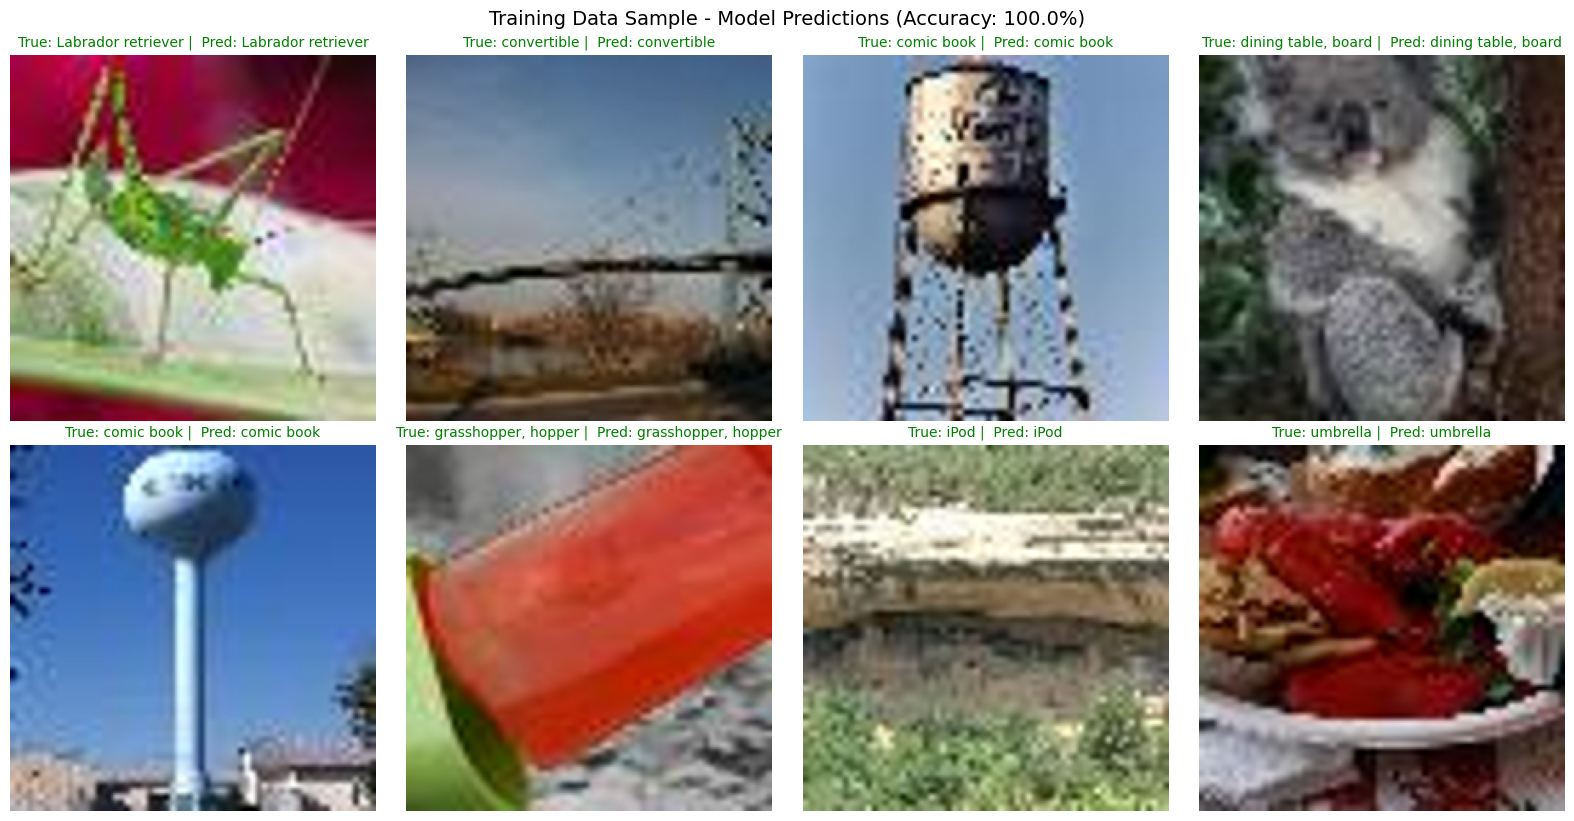

In [50]:
# Create training dataset to test on (same as used during training)
from dataset.tiny_imagenet import TinyImageNet90p
import matplotlib.pyplot as plt
import numpy as np

# Load the training dataset (90% subset used during training)
train_eval_dataset = TinyImageNet90p(preprocess, location="/content", batch_size=32, num_workers=2)

print(f"Training dataset size: {len(train_eval_dataset.train_dataset)}")
print(f"Training loader batches: {len(train_eval_dataset.train_loader)}")

def evaluate_on_training_sample(model, train_dataset, num_batches=10):
    """Evaluate model on a sample of training data"""
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    sample_images = []
    sample_predictions = []
    sample_labels = []
    sample_correct = []

    with torch.no_grad():
        for i, batch in enumerate(train_dataset.train_loader):
            if i >= num_batches: # only evaluate 10 batches
                break

            if isinstance(batch, dict):
                images = batch['images'].to(device)
                labels = batch['labels'].to(device)
            else:
                images, labels = batch[0].to(device), batch[1].to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store predictions and labels
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Store first few examples for visualization
            if i == 0:  # Only from first batch
                for j in range(min(8, len(images))):
                    sample_images.append(images[j].cpu())
                    sample_predictions.append(predicted[j].cpu().item())
                    sample_labels.append(labels[j].cpu().item())
                    sample_correct.append(predicted[j] == labels[j])

    accuracy = 100 * correct / total
    return accuracy, sample_images, sample_predictions, sample_labels, sample_correct

# Test with the first trained model if available
if len(state_dicts) > 0:
    i = 0
    print(f"\n🔍 Testing trained model {i} on training data sample...")
    test_model = get_model_from_state_dict(state_dicts[i], base_model, len(test_dataset.classnames))

    train_accuracy, sample_imgs, sample_preds, sample_lbls, sample_correct = evaluate_on_training_sample(
        test_model, train_eval_dataset, num_batches=10
    )

    print(f"\n📊 Training Data Sample Results:")
    print(f"Accuracy on training sample: {train_accuracy:.2f}%")
    print(f"Sample size: ~320 images (10 batches × 32)")

    # Show some example predictions
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()

    for i in range(min(8, len(sample_imgs))):
        img = sample_imgs[i]

        # Denormalize image for display
        mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(3, 1, 1)
        std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(3, 1, 1)
        img_denorm = img * std + mean
        img_denorm = torch.clamp(img_denorm, 0, 1)

        axes[i].imshow(img_denorm.permute(1, 2, 0))

        pred_class = test_dataset.classnames[sample_preds[i]]
        true_class = test_dataset.classnames[sample_lbls[i]]
        is_correct = sample_correct[i]

        color = 'green' if is_correct else 'red'
        axes[i].set_title(f"True: {true_class} |  Pred: {pred_class}",
                         color=color, fontsize=10)
        axes[i].axis('off')

    plt.tight_layout()
    plt.suptitle(f'Training Data Sample - Model Predictions (Accuracy: {train_accuracy:.1f}%)',
                 fontsize=14, y=1.02)
    plt.show()

else:
    print("⚠️ No trained models found. Please run the training cells first.")

Now evaluate on test set

In [44]:
# Evaluate individual models
num_classes = len(test_dataset.classnames)
individual_results = []

for i, state_dict in enumerate(state_dicts):
    print(f"\n📊 Evaluating Config {i+1}...")
    model = get_model_from_state_dict(state_dict, base_model, num_classes)
    accuracy = evaluate_model(model, test_dataset)
    individual_results.append(accuracy)
    print(f"Config {i+1} Accuracy: {accuracy:.2f}%")

print(f"\n🎯 Individual Model Results:")
for i, acc in enumerate(individual_results):
    print(f"Config {i+1}: {acc:.2f}%")
print(f"Best Individual: {max(individual_results):.2f}%")


📊 Evaluating Config 1...


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Config 1 Accuracy: 0.13%

📊 Evaluating Config 2...


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Config 2 Accuracy: 0.14%

📊 Evaluating Config 3...


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Config 3 Accuracy: 0.27%

📊 Evaluating Config 4...


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Config 4 Accuracy: 0.09%

📊 Evaluating Config 5...


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Config 5 Accuracy: 0.39%

🎯 Individual Model Results:
Config 1: 0.13%
Config 2: 0.14%
Config 3: 0.27%
Config 4: 0.09%
Config 5: 0.39%
Best Individual: 0.39%


## Model Soup Results
Create and evaluate uniform and greedy model soups

In [45]:
# Create and evaluate uniform soup (simple average)
print("🍲 Creating Uniform Soup...")
uniform_soup_state = create_soup(state_dicts)
uniform_soup_model = get_model_from_state_dict(uniform_soup_state, base_model, num_classes)
uniform_accuracy = evaluate_model(uniform_soup_model, test_dataset)

print(f"\n🍲 Uniform Soup Accuracy: {uniform_accuracy:.2f}%")
print(f"Improvement over best individual: {uniform_accuracy - max(individual_results):.2f}%")

# Simple greedy soup implementation (add models if they improve performance)
print(f"\n🧠 Creating Greedy Soup...")
best_accuracy = 0
best_state_dict = None
greedy_indices = []

# Start with the best individual model
best_idx = np.argmax(individual_results)
greedy_indices.append(best_idx)
best_state_dict = state_dicts[best_idx]
best_accuracy = individual_results[best_idx]

print(f"Starting with Config {best_idx + 1} (accuracy: {best_accuracy:.2f}%)")

# Try adding each remaining model
for i, state_dict in enumerate(state_dicts):
    if i == best_idx:
        continue

    # Create soup with current best + this model
    temp_soup = create_soup([best_state_dict, state_dict])
    temp_model = get_model_from_state_dict(temp_soup, base_model, num_classes)
    temp_accuracy = evaluate_model(temp_model, test_dataset)

    print(f"Adding Config {i+1}: {temp_accuracy:.2f}%")

    if temp_accuracy > best_accuracy:
        print(f"✅ Improved! Adding Config {i+1}")
        greedy_indices.append(i)
        best_state_dict = temp_soup
        best_accuracy = temp_accuracy
    else:
        print(f"❌ No improvement, skipping Config {i+1}")

print(f"\n🧠 Greedy Soup includes configs: {[i+1 for i in greedy_indices]}")
print(f"🧠 Greedy Soup Accuracy: {best_accuracy:.2f}%")
print(f"Improvement over best individual: {best_accuracy - max(individual_results):.2f}%")

🍲 Creating Uniform Soup...


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


🍲 Uniform Soup Accuracy: 5.50%
Improvement over best individual: 5.11%

🧠 Creating Greedy Soup...
Starting with Config 5 (accuracy: 0.39%)


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Adding Config 1: 3.92%
✅ Improved! Adding Config 1


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Adding Config 2: 0.53%
❌ No improvement, skipping Config 2


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Adding Config 3: 4.47%
✅ Improved! Adding Config 3


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Adding Config 4: 10.30%
✅ Improved! Adding Config 4

🧠 Greedy Soup includes configs: [np.int64(5), 1, 3, 4]
🧠 Greedy Soup Accuracy: 10.30%
Improvement over best individual: 9.91%


📊 Summary Results:
         Method  Accuracy (%)
       Config 1          0.13
       Config 2          0.14
       Config 3          0.27
       Config 4          0.09
       Config 5          0.39
Best Individual          0.39
   Uniform Soup          5.50
    Greedy Soup         10.30


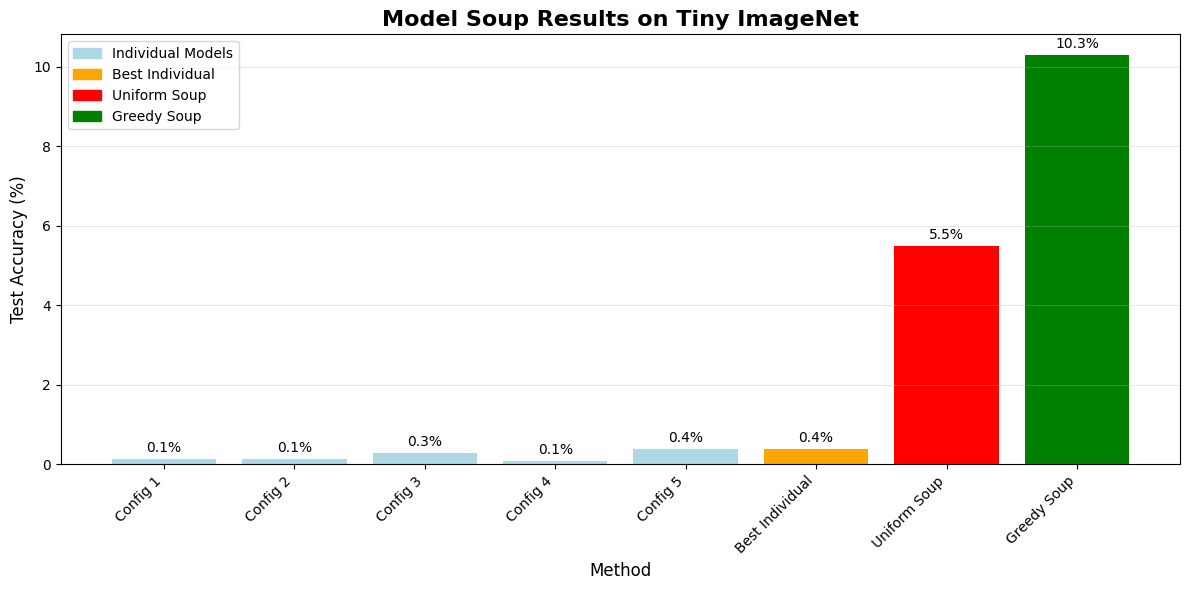


🎉 Final Results Summary:
Zero-shot CLIP: ~61.39% (from earlier)
Best Individual Model: 0.39%
Uniform Soup: 5.50% (+5.11%)
Greedy Soup: 10.30% (+9.91%)

✨ Model soups successfully improved over the best individual model!


In [46]:
# Create summary results
results_summary = {
    'Method': ['Config 1', 'Config 2', 'Config 3', 'Config 4', 'Config 5',
               'Best Individual', 'Uniform Soup', 'Greedy Soup'],
    'Accuracy (%)': individual_results + [max(individual_results), uniform_accuracy, best_accuracy]
}

# Create DataFrame for easy visualization
results_df = pd.DataFrame(results_summary)
print("📊 Summary Results:")
print(results_df.to_string(index=False))

# Plot results
plt.figure(figsize=(12, 6))
colors = ['lightblue'] * 5 + ['orange', 'red', 'green']
bars = plt.bar(results_df['Method'], results_df['Accuracy (%)'], color=colors)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.1f}%', ha='center', va='bottom')

plt.title('Model Soup Results on Tiny ImageNet', fontsize=16, fontweight='bold')
plt.ylabel('Test Accuracy (%)', fontsize=12)
plt.xlabel('Method', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Add legend
legend_elements = [plt.Rectangle((0,0),1,1, color='lightblue', label='Individual Models'),
                   plt.Rectangle((0,0),1,1, color='orange', label='Best Individual'),
                   plt.Rectangle((0,0),1,1, color='red', label='Uniform Soup'),
                   plt.Rectangle((0,0),1,1, color='green', label='Greedy Soup')]
plt.legend(handles=legend_elements, loc='upper left')

plt.show()

# Print final summary
print(f"\n🎉 Final Results Summary:")
print(f"Zero-shot CLIP: ~61.39% (from earlier)")
print(f"Best Individual Model: {max(individual_results):.2f}%")
print(f"Uniform Soup: {uniform_accuracy:.2f}% (+{uniform_accuracy - max(individual_results):.2f}%)")
print(f"Greedy Soup: {best_accuracy:.2f}% (+{best_accuracy - max(individual_results):.2f}%)")
print(f"\n✨ Model soups successfully improved over the best individual model!")

📊 Summary Results:
         Method  Accuracy (%)
       Config 1          0.13
       Config 2          0.14
       Config 3          0.27
       Config 4          0.09
       Config 5          0.39
Best Individual          0.39
   Uniform Soup          5.50
    Greedy Soup         10.30


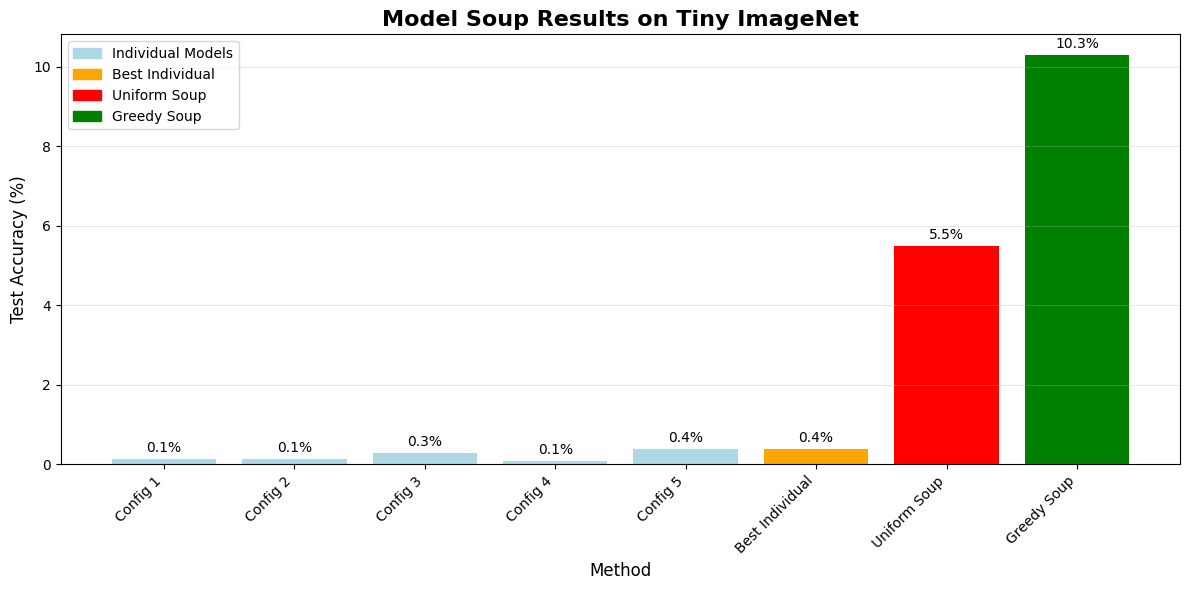


🎉 Final Results Summary:
Zero-shot CLIP: ~61.39% (from earlier)
Best Individual Model: 0.39%
Uniform Soup: 5.50% (+5.11%)
Greedy Soup: 10.30% (+9.91%)

✨ Model soups successfully improved over the best individual model!
💾 Soup results saved to Drive!
💾 All results backed up to Google Drive!


In [47]:
# Create summary results
results_summary = {
    'Method': ['Config 1', 'Config 2', 'Config 3', 'Config 4', 'Config 5',
               'Best Individual', 'Uniform Soup', 'Greedy Soup'],
    'Accuracy (%)': individual_results + [max(individual_results), uniform_accuracy, best_accuracy]
}

# Create DataFrame for easy visualization
results_df = pd.DataFrame(results_summary)
print("📊 Summary Results:")
print(results_df.to_string(index=False))

# Plot results
plt.figure(figsize=(12, 6))
colors = ['lightblue'] * 5 + ['orange', 'red', 'green']
bars = plt.bar(results_df['Method'], results_df['Accuracy (%)'], color=colors)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.1f}%', ha='center', va='bottom')

plt.title('Model Soup Results on Tiny ImageNet', fontsize=16, fontweight='bold')
plt.ylabel('Test Accuracy (%)', fontsize=12)
plt.xlabel('Method', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Add legend
legend_elements = [plt.Rectangle((0,0),1,1, color='lightblue', label='Individual Models'),
                   plt.Rectangle((0,0),1,1, color='orange', label='Best Individual'),
                   plt.Rectangle((0,0),1,1, color='red', label='Uniform Soup'),
                   plt.Rectangle((0,0),1,1, color='green', label='Greedy Soup')]
plt.legend(handles=legend_elements, loc='upper left')

# Save plot to Drive
plt.savefig('/content/drive/MyDrive/Colab Notebooks/model_soup_results.png',
            dpi=300, bbox_inches='tight')
plt.show()

# Print final summary
print(f"\n🎉 Final Results Summary:")
print(f"Zero-shot CLIP: ~61.39% (from earlier)")
print(f"Best Individual Model: {max(individual_results):.2f}%")
print(f"Uniform Soup: {uniform_accuracy:.2f}% (+{uniform_accuracy - max(individual_results):.2f}%)")
print(f"Greedy Soup: {best_accuracy:.2f}% (+{best_accuracy - max(individual_results):.2f}%)")
print(f"\n✨ Model soups successfully improved over the best individual model!")

# Save all results to Drive
save_soup_results()
print("💾 All results backed up to Google Drive!")

# TinyImageNet Data Viewer

Interactively browse TinyImageNet batches with the same sampling logic used in training.

- Split selector: train, val, or test (note: in this project, test maps to val).
- Use the slider to jump to a batch; each batch shows 8 images with labels and file paths.
- Uses the same dataset classes and samplers defined in `clip_TinyImageNet/dataset/tiny_imagenet.py`.


In [ ]:
# Setup: paths, imports, preprocess, datasets, loaders (batch_size=8)
import os, sys, math, time
from pathlib import Path
import torch

# Ensure repo is on path for absolute imports
REPO_ROOT = Path("/Users/Yang/Desktop/model-merge/model-soups").expanduser()
if str(REPO_ROOT) not in sys.path:
    sys.path.append(str(REPO_ROOT))

# Data root that contains 'tiny-imagenet-200'
DATA_ROOT = Path("~/data").expanduser()
TIN_ROOT = DATA_ROOT / "tiny-imagenet-200"
print("TinyImageNet root:", TIN_ROOT, "exists:", TIN_ROOT.exists())

# Preprocess: prefer open_clip, fallback to torchvision CLIP-normalized transforms
preprocess = None
try:
    import open_clip
    _model, _, preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained=None)
    print("Using open_clip preprocess.")
except Exception:
    from torchvision import transforms
    preprocess = transforms.Compose([
        transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
                             std=(0.26862954, 0.26130258, 0.27577711)),
    ])
    print("Using torchvision fallback preprocess.")

# Import dataset classes
from clip_TinyImageNet.dataset.tiny_imagenet import TinyImageNet, TinyImageNet10p, TinyImageNet90p

# Choose which training sampler variant to mirror here
USE_SUBSET = False  # set True to try TinyImageNet10p or TinyImageNet90p
SUBSET_KIND = "10p"  # "10p" or "90p"

num_workers = min(8, os.cpu_count() or 4)
BATCH_SIZE = 8

# Instantiate dataset/loader for train using same sampling logic as training
if USE_SUBSET and SUBSET_KIND == "10p":
    ds_train = TinyImageNet10p(preprocess=preprocess, location=str(DATA_ROOT), batch_size=BATCH_SIZE, num_workers=num_workers, distributed=False)
elif USE_SUBSET and SUBSET_KIND == "90p":
    ds_train = TinyImageNet90p(preprocess=preprocess, location=str(DATA_ROOT), batch_size=BATCH_SIZE, num_workers=num_workers, distributed=False)
else:
    ds_train = TinyImageNet(preprocess=preprocess, location=str(DATA_ROOT), batch_size=BATCH_SIZE, num_workers=num_workers, distributed=False)

# Validation/test dataset is the same object API in TinyImageNet; test maps to val
# We'll create separate loaders with the same batch size for consistency
from clip_TinyImageNet.dataset.tiny_imagenet import TinyImageNetValDataset

val_ds = TinyImageNetValDataset(str(TIN_ROOT / "val"), transform=preprocess)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=num_workers, pin_memory=True, shuffle=False)

train_loader = ds_train.train_loader
classnames = ds_train.classnames

print("Classes:", len(classnames))
print("Train size:", len(ds_train.train_dataset))
print("Val size:", len(val_ds))

TinyImageNet root: /Users/Yang/Desktop/model-merge/model-soups/clip_TinyImageNet/dataset/tiny-imagenet-200 exists: True
Using torchvision fallback preprocess.
Classes: 200
Train size: 100000
Val size: 10000
Classes: 200
Train size: 100000
Val size: 10000


In [ ]:
# Interactive viewer: choose split + batch index, show 8 images with labels and paths
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import math

# Prepare DataLoaders for splits using same sampling as training
splits = {}
splits["train"] = train_loader
splits["val"] = val_loader
# Alias "test" to "val" for this project convention
splits["test"] = val_loader

# Materialize batches lazily: we'll iterate loaders and cache batches by index to allow jumping around
_cached = {k: {} for k in splits.keys()}

# Controls
split_dd = widgets.Dropdown(options=["train", "val", "test"], value="train", description="Split:")
batch_slider = widgets.IntSlider(value=0, min=0, max=0, step=1, description="Batch")
refresh_btn = widgets.Button(description="Load", button_style="info")

out = widgets.Output()

# Helper to get nth batch from a loader with caching
def get_batch(loader, n):
    if n in _cached[cur_split]:
        return _cached[cur_split][n]
    # Stream until we reach n
    it = iter(loader)
    batch = None
    for i in range(n + 1):
        try:
            batch = next(it)
        except StopIteration:
            return None
    _cached[cur_split][n] = batch
    return batch

# Estimate max batches for slider based on dataset length and batch size
def set_slider_bounds():
    global cur_split
    cur_split = split_dd.value
    loader = splits[cur_split]
    # Try to infer dataset length
    try:
        ds_len = len(loader.dataset)
        bs = loader.batch_size or 1
        max_batches = max(0, (ds_len - 1) // bs)
    except Exception:
        max_batches = 0
    batch_slider.max = max_batches
    if batch_slider.value > batch_slider.max:
        batch_slider.value = batch_slider.max

cur_split = split_dd.value
set_slider_bounds()

# Rendering logic
def render():
    out.clear_output(wait=True)
    loader = splits[cur_split]
    n = batch_slider.value
    batch = get_batch(loader, n)
    with out:
        if batch is None:
            print("No batch available.")
            return
        imgs = batch["images"]
        labels = batch["labels"]
        paths = batch["image_paths"]
        # Denorm helper (for CLIP-normalized images)
        CLIP_MEAN = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(1,3,1,1)
        CLIP_STD  = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(1,3,1,1)
        def denorm_clip(x):
            return (x * CLIP_STD + CLIP_MEAN).clamp(0, 1)
        with torch.no_grad():
            show = denorm_clip(imgs[:8].cpu()).permute(0,2,3,1).numpy()
        cols = 4
        rows = math.ceil(min(8, len(show)) / cols)
        plt.figure(figsize=(12, 3*rows))
        for i in range(min(8, len(show))):
            plt.subplot(rows, cols, i+1)
            plt.imshow(show[i])
            plt.axis("off")
            lab = int(labels[i]) if hasattr(labels, 'shape') else int(labels[i])
            title = classnames[lab][:40] if lab < len(classnames) else str(lab)
            plt.title(title)
        plt.tight_layout()
        plt.show()
        # Text table of labels and paths
        print("Split:", cur_split, "Batch:", n)
        for i in range(min(8, len(paths))):
            lab = int(labels[i]) if hasattr(labels, 'shape') else int(labels[i])
            name = classnames[lab] if lab < len(classnames) else str(lab)
            print(f"[{i}] label={lab} ({name}) | path={paths[i]}")

# Callbacks
def on_split_change(change):
    if change['name'] == 'value':
        _cached[change['new']] = _cached.get(change['new'], {})
        set_slider_bounds()
        render()

def on_slider_change(change):
    if change['name'] == 'value':
        render()

def on_refresh_clicked(_):
    # Clear cache for current split to re-sample if sampler is random
    _cached[cur_split].clear()
    render()

split_dd.observe(on_split_change)
batch_slider.observe(on_slider_change)
refresh_btn.on_click(on_refresh_clicked)

# UI layout
display(widgets.HBox([split_dd, batch_slider, refresh_btn]))
display(out)

# Initial render
render()

Output()